In [ ]:
#做空策略(包含借贷利息)
#期货杠杆安全区
#击穿位下次购买时的精确价格(追单滑点)
#交易次数及最大回撤(即亏损单的最大损失)
#平仓的策略来实现利润最大化

In [3]:
import tushare as ts

In [4]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
#设置好需要用到的参数
#向前看的天数（设置开始日期为多少天之前）
days_count = 365
#股票代码
stock_code = '000001.SZ'
#市场类型
market_type = 'stock'
#移动平均天数
MA_dates = 7
#使用多长时间的K线图
#K_dates = 1
#使用何种K线图，可以选择‘daily’/‘weekly’/‘monthly’
K_type = 'daily'
#每笔交易费用
transaction_fee_rate = 0.0008
#滑点费用
slippage_fee_rate = 0.002
#利息费用
interest_fee_rate = 0.001
#利息的种类，可以选择按天的D，按月的M
interest_type = 'D'
#杠杆费用
leverage_fee_rate = 0.001
#初始资金
start_money = 10000

In [8]:
now = datetime.datetime.now()
delta = datetime.timedelta(days=days_count)

n_days = now - delta
start_date = n_days.strftime('%Y%m%d')
print (start_date)

20180805


In [9]:
#读取tushare的token
pro = ts.pro_api('6f92d455dd39756f84ddb2c7a785c346e6c3bfa7cafd9bcaedf9b4e9')

In [8]:
total_list = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code, symbol, name, area, industry, list_date')

In [9]:
total_list

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,000001,平安银行,深圳,银行,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,19910129
2,000004.SZ,000004,国农科技,深圳,生物制药,19910114
3,000005.SZ,000005,世纪星源,深圳,环境保护,19901210
4,000006.SZ,000006,深振业A,深圳,区域地产,19920427
5,000007.SZ,000007,全新好,深圳,酒店餐饮,19920413
6,000008.SZ,000008,神州高铁,北京,运输设备,19920507
7,000009.SZ,000009,中国宝安,深圳,综合类,19910625
8,000010.SZ,000010,*ST美丽,深圳,建筑施工,19951027
9,000011.SZ,000011,深物业A,深圳,区域地产,19920330


In [10]:
single_stock = pro.query('weekly', ts_code=stock_code, start_date=start_date, fields = 'ts_code, trade_date, open, high, low, close')

In [11]:
single_stock.head()

,ts_code,trade_date,close,open,high,low
0,000001.SZ,20190726,14.23,13.96,14.27,13.65
1,000001.SZ,20190719,13.99,14.03,14.12,13.56
2,000001.SZ,20190712,14.12,13.82,14.23,13.44
3,000001.SZ,20190705,13.92,14.01,14.28,13.69
4,000001.SZ,20190628,13.78,13.69,13.85,13.07


In [93]:
rev_stock = single_stock.iloc[::-1].reset_index(drop = True)

In [94]:
rev_stock['MA'] = rev_stock['close'].rolling(window=MA_dates).mean()

In [95]:
rev_stock.head()

,ts_code,trade_date,open,high,low,close,MA
0,000001.SZ,20180604,10.23,10.31,10.15,10.27,NaN
1,000001.SZ,20180605,10.29,10.30,10.11,10.26,NaN
2,000001.SZ,20180606,10.25,10.26,10.10,10.14,NaN
3,000001.SZ,20180607,10.20,10.46,10.18,10.37,NaN
4,000001.SZ,20180608,10.33,10.33,10.06,10.12,NaN


In [10]:
def pltStockMA(rev_stock):
    plt.figure()
    plt.figure(figsize=(20,8))
    xs = [datetime.datetime.strptime(d, '%Y%m%d').date() for d in rev_stock['trade_date']]
    # 配置横坐标
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))
    plt.plot(xs, rev_stock['close'], label = 'close')
    plt.plot(xs, rev_stock['MA'], label = 'MA')
    plt.axis()
    plt.gcf().autofmt_xdate()  # 自动旋转日期标记
    plt.title("K-line-%s and MA-%s on %s"%(K_type, MA_dates, stock_code))
    plt.xlabel("Dates")
    plt.ylabel("price")
    plt.legend(loc = 'lower right')
    plt.grid()
    plt.show()
    return()
#plt.savefig(plot_save_path+'/'+graph_type+'_PR_Curve')

In [11]:
#计算回测收益的函数
#规则为在时间窗口内的第一次收盘价的值大于MA值之后的第二天开盘价买入，然后在接下来的每次收盘价的值小于MA值之后的第二天开盘价卖出
#暂时没考虑做空
def lookback_profit(start_money, rev_stock, show_process=False):
    position_status = 0
    position_shares = 0
    total_transaction_time = 0
    total_buyin_time = 0
    total_sell_time = 0
    transaction_share = 0
    transaction_fee_total = 0
    available_money = start_money
    for i in range(len(rev_stock)-1):
        if (position_status == 0) and (rev_stock['close'][i] > rev_stock['MA'][i]):
            position_status = 1 
            transaction_price = rev_stock['open'][i+1]
            transaction_share = available_money/transaction_price
            #手续费为手续费（暂时没有加上滑点费用）
            transaction_fee = transaction_price * transaction_share * transaction_fee_rate
            transaction_fee_total += transaction_fee
            available_money = 0
            total_asset = available_money + transaction_price*transaction_share - transaction_fee
            total_transaction_time += 1
            total_buyin_time += 1
            if (show_process == True):
                print('Breakdown Time: %d '%total_transaction_time)
                print('Buyin Time: %d'%total_buyin_time)
                print('Breakdown Date: %s '%rev_stock['trade_date'][i])
                print('Transaction Date: %s '%rev_stock['trade_date'][i+1])
                print('Transaction Type: %d '%position_status)
                print('Transaction Price: %f '%transaction_price)
                print('Transaction Share: %f '%transaction_share)
                print('Total Asset: %f\n '%total_asset)
        if (position_status == 1) and (rev_stock['close'][i] < rev_stock['MA'][i]):
            position_status = 0
            transaction_price = rev_stock['open'][i+1]
            #transaction_share = transaction_share
            transaction_fee = transaction_price * transaction_share * transaction_fee_rate
            transaction_fee_total += transaction_fee
            available_money += transaction_price * transaction_share - transaction_fee
            total_asset = available_money
            total_transaction_time += 1
            total_sell_time += 1
            if (show_process == True):
                print('Breakdown Time: %d '%total_transaction_time)
                print('Sell Time: %d'%total_sell_time)
                print('Breakdown Date: %s '%rev_stock['trade_date'][i])
                print('Transaction Date: %s '%rev_stock['trade_date'][i+1])
                print('Transaction Type: %d '%position_status)
                print('Transaction Price: %f '%transaction_price)
                print('Transaction Share: %f '%transaction_share)
                print('Total Asset: %f\n '%total_asset)
    final_asset = total_asset
    final_profit = final_asset - start_money
    final_profit_rate = final_profit / start_money
    print ('Final profit rate: %f'%final_profit_rate)
    print ('Total transaction fee: %f'%transaction_fee_total)
    return (final_profit_rate)

#lookback_profit(start_money, rev_stock)


In [12]:
def calculate_profit_for_single_stock(start_money, days_count, stock_code, MA_dates, K_type, transaction_fee_rate, show_process=False):
    #得到开始日期
    now = datetime.datetime.now()
    delta = datetime.timedelta(days=days_count)
    n_days = now - delta
    start_date = n_days.strftime('%Y%m%d')
    
    #得到时间对应的股票价格走势表格
    single_stock = pro.query(K_type, ts_code=stock_code, start_date=start_date, fields = 'ts_code, trade_date, open, high, low, close')
    rev_stock = single_stock.iloc[::-1].reset_index(drop = True)
    rev_stock['MA'] = rev_stock['close'].rolling(window=MA_dates).mean()
    
    pltStockMA(rev_stock)
    
    start_price = list(rev_stock['open'])[0]
    end_price = list(rev_stock['open'])[-1]
    profit_original = (end_price-start_price)/start_price
    print ('Original profit rate: %f'%profit_original)
    
    profit_rate = lookback_profit(start_money, rev_stock, show_process)
    return(profit_rate, profit_original)

In [13]:
def calculate_annual_profit(days, profit):
    start_value = 1
    after_value = 1+profit
    daily_profit = after_value ** (1/days)
    annual_profit = daily_profit ** 365 - 1 
    return(annual_profit)

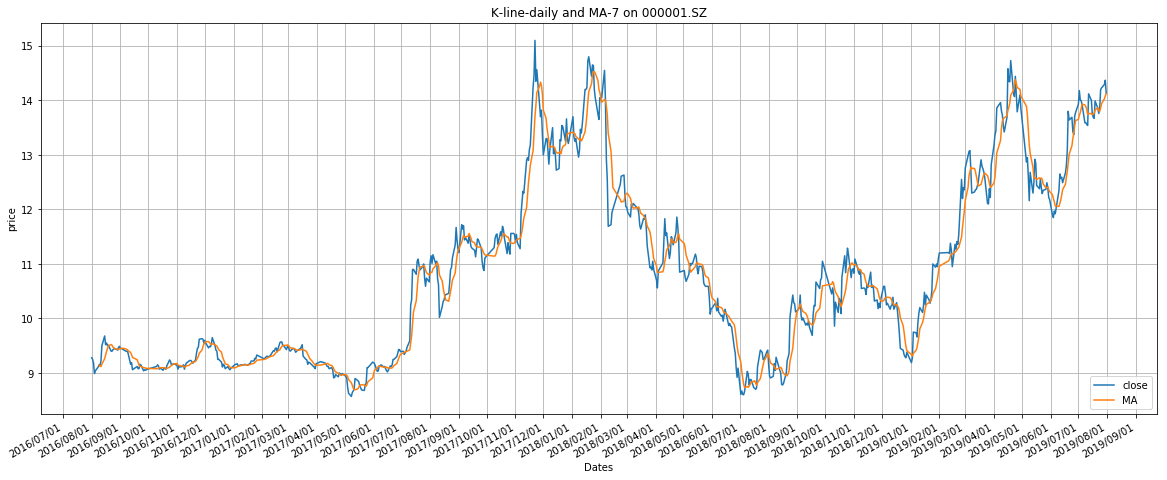

Original profit rate: 0.557734
Final profit rate: 0.263880
Total transaction fee: 1385.400937


(0.2638804540727175, 0.5577342047930285)

In [23]:
calculate_profit_for_single_stock(10000, 365*3, '000001.SZ', 7, 'daily', 0.0008)

In [15]:
MA_dates_list = range(7,8)
Time_periods = [365]
K_type_list = ['daily', 'weekly']

In [14]:
def grid_search_single_stock(start_money, Time_periods, stock_code, MA_dates_list, K_type_list, transaction_fee_rate, show_process=False):
    return_df = pd.DataFrame()
    profit_rate_list = []
    k_type_list = []
    ma_dates_list = []
    time_periods_list = []
    profit_annual_list = []
    profit_original_list = []
    profit_original_annual_list = []
    profit_annual_win_list = []
    for k in K_type_list:
        for j in Time_periods: 
            for i in MA_dates_list:
                k_type_list.append(k)
                ma_dates_list.append(i)
                time_periods_list.append(j)
                profit_rate, profit_original = calculate_profit_for_single_stock(start_money, j, stock_code, i, k, transaction_fee_rate, show_process)
                profit_rate_list.append(profit_rate)
                profit_original_list.append(profit_original)
                profit_annual = calculate_annual_profit(j, profit_rate)
                profit_annual_list.append(profit_annual)
                profit_original_annual = calculate_annual_profit(j, profit_original)
                profit_original_annual_list.append(profit_original_annual)
                profit_annual_win_list.append(profit_annual-profit_original_annual)
    return_df['K_type'] = k_type_list
    return_df['MA_dates'] = ma_dates_list
    return_df['Time_periods'] = time_periods_list
    return_df['Profit_rate'] = profit_rate_list
    return_df['Profit_rate_annual'] = profit_annual_list
    return_df['Profit_original'] = profit_original_list
    return_df['Profit_original_annual'] = profit_original_annual_list
    return_df['Profit_annual_win'] = profit_annual_win_list
    return (return_df)

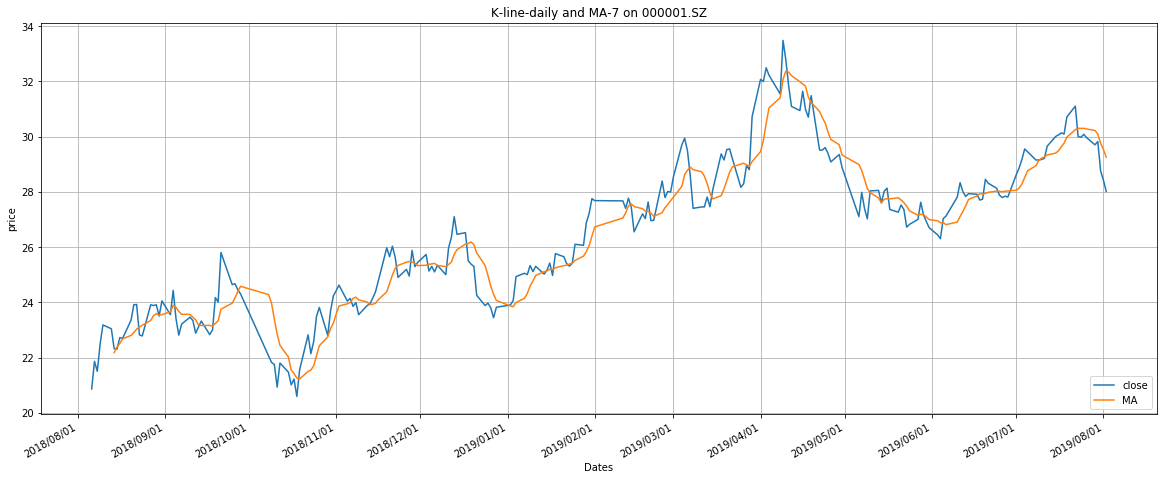

Original profit rate: 0.310198
Final profit rate: -0.082821
Total transaction fee: 403.037336


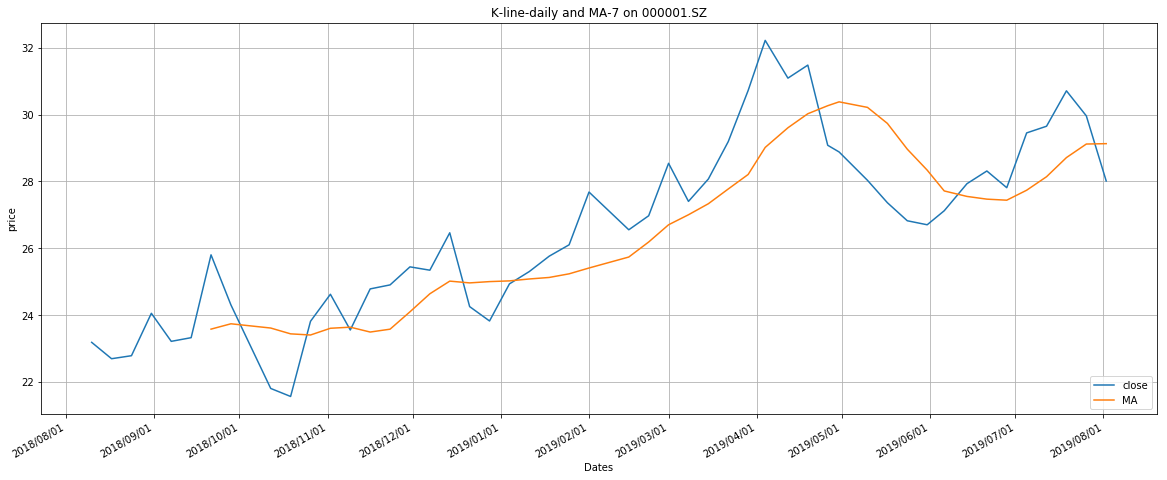

Original profit rate: 0.412653
Final profit rate: -0.057155
Total transaction fee: 63.775561


In [17]:
a=grid_search_single_stock(start_money, Time_periods, '000002.SZ', MA_dates_list, K_type_list, transaction_fee_rate)

In [163]:

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(return_df)

    MA_dates  Time_periods  Profit_rate  Profit_rate_annual  Profit_original  \
0          7           182     0.121851            0.259345         0.124882   
1          8           182     0.158275            0.342686         0.124882   
2          9           182     0.180844            0.395667         0.124882   
3         10           182     0.172468            0.375884         0.124882   
4         11           182     0.259052            0.587219         0.124882   
5         12           182     0.237942            0.534300         0.124882   
6         13           182     0.260233            0.590208         0.124882   
7         14           182     0.192502            0.423436         0.124882   
8         15           182     0.212203            0.470990         0.124882   
9         16           182     0.275339            0.628664         0.124882   
10        17           182     0.257534            0.583385         0.124882   
11        18           182     0.271751 

In [167]:
return_df.to_csv('return_0605.csv')

In [19]:
a.

TypeError: 'method' object is not subscriptable